# 3. 학습/예측/평가

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set(font_scale=1.5)
%matplotlib inline
color = sns.color_palette()

PATH = '/content/drive/MyDrive/instacart/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

train_df = pd.read_pickle(PATH + 'train_df1.pkl')
test_df = pd.read_pickle(PATH + 'test_df1.pkl')

# 훈련 데이터와 타겟 분리
X = train_df.drop('reordered', axis=1)
y = train_df['reordered']

## LGBM

1. 모델 : LGBM 사용
2. CV : 유저별로 나눈 Kfold 사용.
3. 평가지표 : F1


1. train_df에서 타겟을 제외하고 X로, 타겟은 y로 나눈다.
2. CV을 위해 GroupKFold 그룹을 나누고 cross_val_predict로 예측값을 뽑는다.
3. precision_recall_curve로 threshold에 따라 precision과 recall의 변화를 확인한다. 적절한 threshold를 찾는다. 
4. 찾은 threshold를 사용해서 레이블을 예측하고 f1 score를 확인한다.


In [ ]:
!pip uninstall lightgbm
!pip install lightgbm --install-option=--gpu

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import RandomizedSearchCV

clf_lgbm = LGBMClassifier(device_type="gpu") # 모델
# distributions = dict(learning_rate = [0.01, 0.1, 0.2, 0.3],n_estimators = [500, 1000, 1500],max_depth = [5, 10, 15, 20],num_leaves=[50, 75, 100],class_weight=[{0:1,1:2},{0:1,1:4},{0:1,1:6}]) 

# lgbm_Randomized = RandomizedSearchCV(clf_lgbm,param_distributions=distributions,scoring='f1',return_train_score=True,cv=3)
# lgbm_Randomized.fit(X, y)
# lgbm_Randomized.best_params_

gkf = GroupKFold(n_splits=3)  # Group KFold
gkf = gkf.split(X, y, groups=X['user_id'].values)

y_scores = cross_val_predict(clf_lgbm, X, y, cv=gkf, method='predict_proba')
y_scores

array([[0.14903758, 0.85096242],
       [0.17094973, 0.82905027],
       [0.18794079, 0.81205921],
       ...,
       [0.97484814, 0.02515186],
       [0.82946907, 0.17053093],
       [0.97371473, 0.02628527]])

In [ ]:
lgbm_Randomized.best_params_

{'class_weight': {0: 1, 1: 4},
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 1500,
 'num_leaves': 75}

In [ ]:
# precision, recall, threshold 뽑아내기
precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:,1])

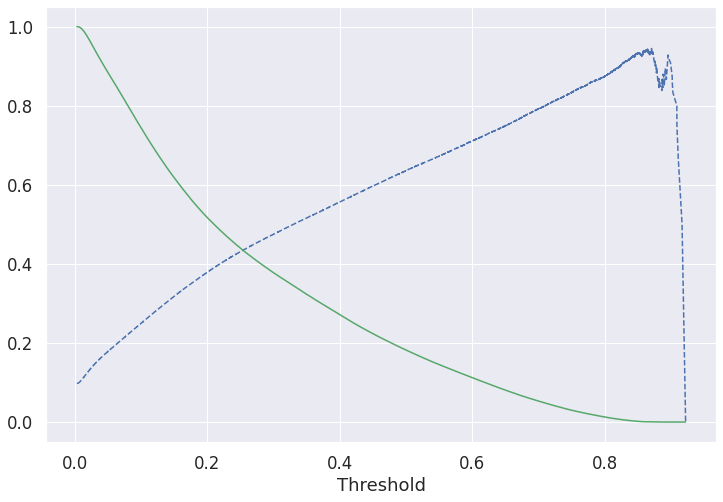

In [ ]:
# threshold에 따른 precision과 recall의 trade_off 확인하기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recalls')
    plt.xlabel('Threshold')
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

0.2와 0.3이 사이가 가장 좋아보인다. 정확하게 확인해본다.

In [ ]:
for thre in range(20, 30):
    temp_thre = thre * 0.01
    temp_y_pred = (y_scores[:, 1] >= temp_thre).astype(np.uint8)
    print('threshold :', temp_thre, f1_score(y, temp_y_pred))

threshold : 0.2 0.43737320702216037
threshold : 0.21 0.4383636599363393
threshold : 0.22 0.4386332018746674
threshold : 0.23 0.438161172032991
threshold : 0.24 0.4369868435505965
threshold : 0.25 0.4352789959623133
threshold : 0.26 0.433079902716993
threshold : 0.27 0.4307147019754308
threshold : 0.28 0.4277014813189331
threshold : 0.29 0.4244160750899295


0.22가 0.4371로 f1 score가 가장 높다.

In [ ]:
y_scores_22 = (y_scores[:, 1] >= 0.22).astype(np.uint8)
f1_score(y, y_scores_22)

0.4386332018746674

In [ ]:
# 훈련
clf_lgbm = LGBMClassifier(class_weight={0: 1, 1: 4},learning_rate=0.01,max_depth=10,n_estimators=1500,num_leaves=75,device_type="gpu") #learning_rate=0.1,max_depth=15,n_estimators=1000,num_leaves=75,class_weight={0:1,1:4}
clf_lgbm.fit(X, y)

LGBMClassifier(class_weight={0: 1, 1: 4}, device_type='gpu', learning_rate=0.01,
               max_depth=10, n_estimators=1500, num_leaves=75)

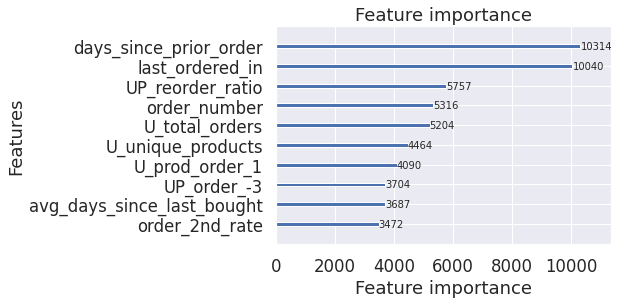

In [ ]:
from lightgbm import plot_importance
plot_importance(clf_lgbm, max_num_features=10)

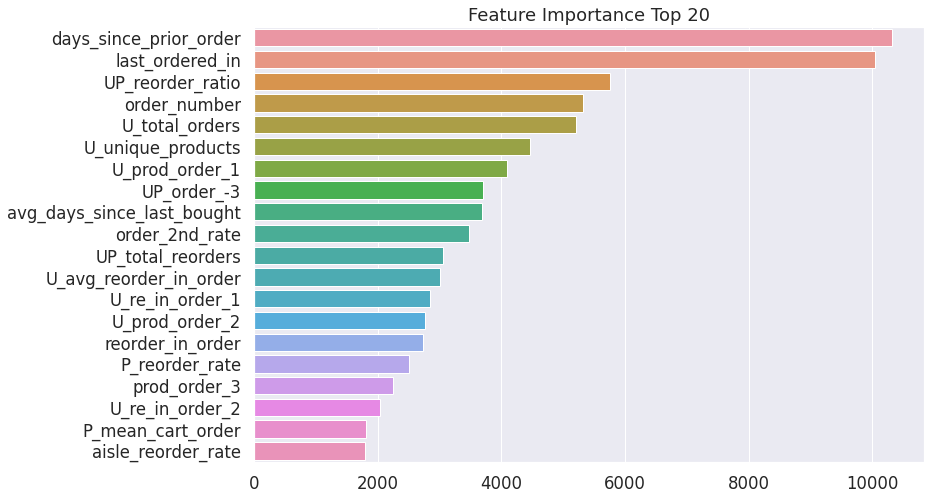

In [ ]:
import seaborn as sns

ft_importance_values = clf_lgbm.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(12,8))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [ ]:
# 예측
# predict_proba로 예측 확률을 뽑아낸다.

y_pred = clf_lgbm.predict_proba(test_df)
y_pred.shape

(4833292, 2)

In [ ]:
# 위에서 찾은 threshold를 기준으로 타겟을 변환한다.
final_y_pred = (y_pred[:, 1] >= 0.22).astype(np.uint8)

threshold를 통과한 타겟을 이용해서 제출 형식에 맞추기 위해서 test 셋에 컬럼으로 추가해준다.

In [ ]:
# 데이터에 추가하기
test_df['reordered'] = final_y_pred

In [ ]:
test_df.head()

,user_id,product_id,UP_total_reorders,UP_mean_cart_order,UP_order_-3,UP_order_-2,UP_order_-1,UP_reorder_ratio,aisle_id,department_id,...,last_ordered_in,unique_users,order_2nd_rate,aisle_std_add_to_cart_order,aisle_unique_users,department_std_add_to_cart_order,department_unique_users,average_order_size,reorder_in_order,reordered
120,3,39190,9,1.799805,1,1,1,0.818359,91,16,...,12,4678,0.430526,6.263454,96326,6.611611,190565,7.333333,0.71871,1
121,3,47766,8,3.777344,1,1,1,0.727051,24,4,...,12,42771,0.641299,6.280129,177141,6.658899,193237,7.333333,0.71871,1
122,3,21903,7,4.250000,1,1,-1,0.636230,123,4,...,12,55037,0.664226,6.777572,159418,6.658899,193237,7.333333,0.71871,1
123,3,9387,4,3.599609,-1,-1,-1,0.363525,24,4,...,7,12650,0.469170,6.280129,177141,6.658899,193237,7.333333,0.71871,1
124,3,17668,4,3.599609,1,1,-1,0.363525,91,16,...,11,890,0.383146,6.263454,96326,6.611611,190565,7.333333,0.71871,1


### submission 생성/제출

In [ ]:
sample = pd.read_csv(PATH + 'sample_submission.csv')
orders = pd.read_pickle(PATH + 'orders.pkl')

In [ ]:
sub = orders[orders.eval_set == 'test'][['order_id', 'user_id']].reset_index(drop=True)
sub_prods = test_df[test_df['reordered'] == 1].groupby('user_id')['product_id'].agg(lambda x: ' '.join(map(str,x))).reset_index()
sub_prods.head()

In [ ]:
# sub에 병합한다. 위에서 포함되지 않는 user는 병합시 결측치가 된다. 
sub = sub.merge(sub_prods, on='user_id', how='left')
sub.drop('user_id', axis=1, inplace=True)
sub.fillna('None', inplace=True)
sub

,order_id,product_id_x,product_id_y
0,2774568,39190 47766 21903 9387 17668 18599 43961 1819 ...,39190 47766 21903 9387 17668 18599 43961 1819 ...
1,329954,39190 47766 21903 9387 17668 18599 43961 1819 ...,35469 17769 19057 37646
2,1528013,39190 47766 21903 9387 17668 18599 43961 1819 ...,21903 38293 8424 11068 20323 25659 27521 40992...
3,1376945,39190 47766 21903 9387 17668 18599 43961 1819 ...,8309 27959 14947 35948 8670 28465 34658 35640 ...
4,1356845,39190 47766 21903 9387 17668 18599 43961 1819 ...,7076 10863 13176 14992 5746 8239 20350 21616 2...
...,...,...,...
74995,2728930,39190 47766 21903 9387 17668 18599 43961 1819 ...,26620 2693 24852 35640 432 9450 38837 49683 12...
74996,350108,39190 47766 21903 9387 17668 18599 43961 1819 ...,30561 43961 5646 10199 15649 21137 42828 48287...
74997,1043943,39190 47766 21903 9387 17668 18599 43961 1819 ...,38530 11520 27086 13045 23029 42623 45139 4568...
74998,2821651,39190 47766 21903 9387 17668 18599 43961 1819 ...,44632 3397 13176 36011 33787 39180 27966 2954 ...


In [ ]:
sub.drop('product_id_x', axis=1, inplace=True)

In [ ]:
# 서브미션 저장
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

## lgbm 결과 정리
* lgbm 모델은 파라미터 값을 튜닝하는것보다 값을 주지 않은 baseline 모델이 성능이 더 높게 나왔습니다.
1. base_model_lgbm_53 : 피처 추가(53개), parameter 튜닝 X **0.37611**
2. bass_model_lgbm : parameter 튜닝 X **0.37545**
3. lgbm_53_v3 : parameter[class_weight={0: 1, 1: 4},learning_rate=0.01,max_depth=10,n_estimators=1500,num_leaves=75] **0.30825**
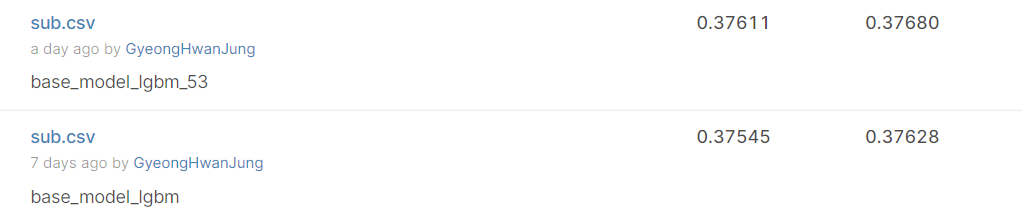
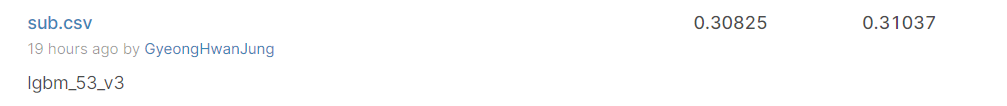


### Feature Importance
- 공통적으로 중요도가 높은 피처 : ***order_number, days_since_prior_order, P_reorder_rate, UP_order_-3, UP_reorder_ratio***
1. base_model_lgbm(파라미터 튜닝 X), 캐글 private:**0.37545**
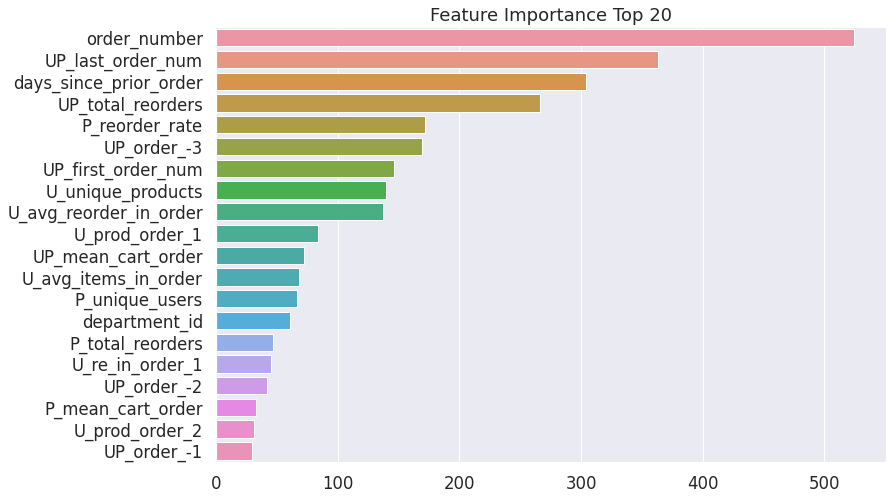

2. lgbm_v2(reoder_ratio를 비롯한 피처들 추가하고 돌린 결과, 파라미터 X), 캐글:0.37286
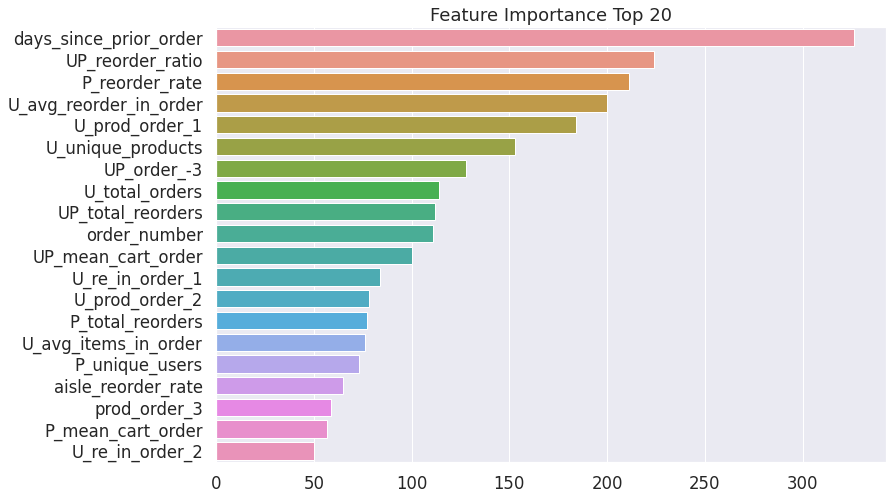

3. base_model_lgbm_53(피처 53개로 늘림, 파라미터 튜닝X), 캐글:0.37611
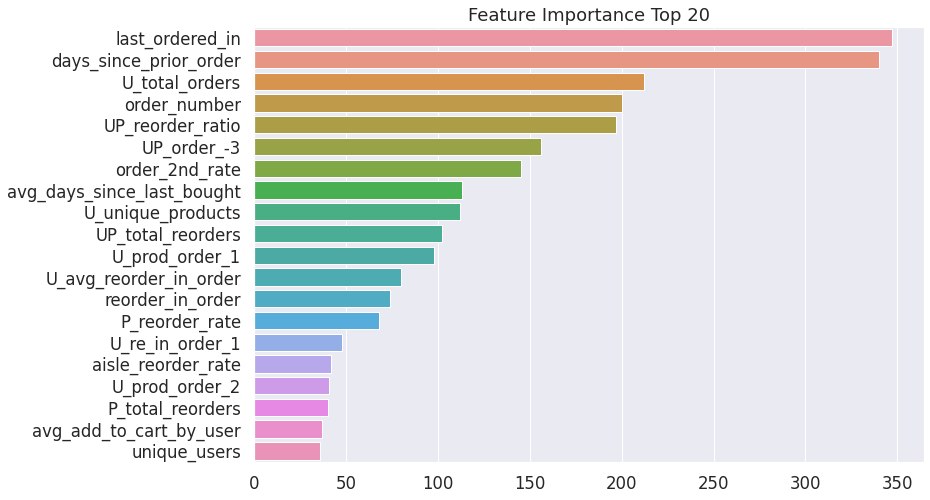

## XGBoost

In [ ]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import RandomizedSearchCV

clf_xgb = XGBClassifier(tree_method = "gpu_hist") # 모델
# distributions = dict(learning_rate = [0.01, 0.1, 0.2, 0.3, 0.4],n_estimators = [100, 200, 300, 400, 500, 600],max_depth = [4, 6, 8, 10]) 

# xgb_Randomized = RandomizedSearchCV(clf_xgb,param_distributions=distributions,scoring='f1',return_train_score=True,cv=3)
# xgb_Randomized.fit(X, y)
# xgb_Randomized.best_params_

gkf = GroupKFold(n_splits=3)  # Group KFold
gkf = gkf.split(X, y, groups=X['user_id'].values)

y_scores = cross_val_predict(clf_xgb, X, y, cv=gkf, method='predict_proba')

In [ ]:
#xgb_Randomized.best_params_ # 'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 400

In [ ]:
# precision, recall, threshold 뽑아내기
precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:,1])

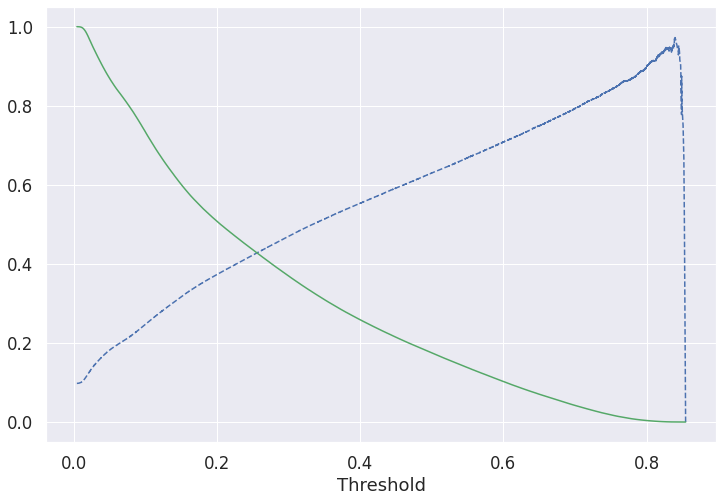

In [ ]:
# threshold에 따른 precision과 recall의 trade_off 확인하기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recalls')
    plt.xlabel('Threshold')
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
for thre in range(20, 30):
    temp_thre = thre * 0.01
    temp_y_pred = (y_scores[:, 1] >= temp_thre).astype(np.uint8)
    print('threshold :', temp_thre, f1_score(y, temp_y_pred))

threshold : 0.2 0.43014113170998836
threshold : 0.21 0.4310476090985785
threshold : 0.22 0.4312700726273427
threshold : 0.23 0.4311007863881084
threshold : 0.24 0.43016524181680044
threshold : 0.25 0.4289425402484092
threshold : 0.26 0.4270250525803554
threshold : 0.27 0.4244158339329517
threshold : 0.28 0.42141451242998157
threshold : 0.29 0.41784656821598887


In [ ]:
# train_x = train_df.values
# test_x = test_df.values

In [ ]:
clf_xgb = XGBClassifier(learning_rate=0.3, max_depth=4, n_estimators=400, tree_method="gpu_hist",)
clf_xgb.fit(X, y)

y_pred = clf_xgb.predict_proba(test_df)
final_y_pred = (y_pred[:, 1] >= 0.22).astype(np.uint8)
test_df['reordered'] = final_y_pred

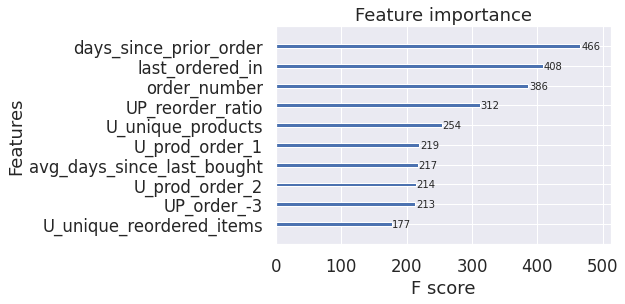

In [ ]:
from xgboost import plot_importance
plot_importance(clf_xgb, max_num_features=10)

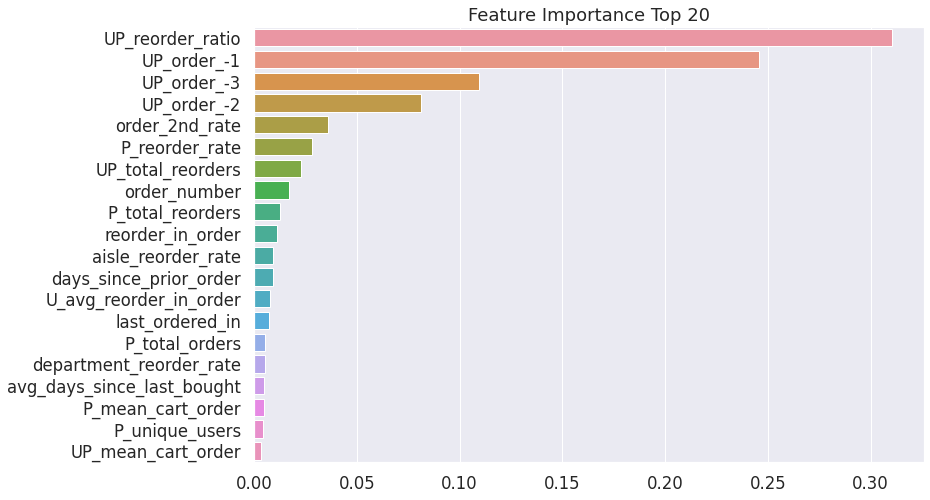

In [ ]:
import seaborn as sns

ft_importance_values = clf_xgb.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(12,8))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

### submission 생성/제출

In [ ]:
orders = pd.read_pickle(PATH + 'orders.pkl')

sub = orders[orders.eval_set == 'test'][['order_id', 'user_id']].reset_index(drop=True)

sub_prods = test_df[test_df['reordered'] == 1].groupby('user_id')['product_id'].agg(lambda x: ' '.join(map(str,x))).reset_index()

sub = sub.merge(sub_prods, on='user_id', how='left')
sub.drop('user_id', axis=1, inplace=True)
sub.fillna('None', inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

#### 캐글 API 키를 사용해서 바로 submit하기

In [ ]:
# 캐글 API 키 설정 사용하기
!mkdir -p ~/.kaggle
%cd /content/drive/MyDrive/
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle
%cd /content

# submit코드
!kaggle competitions submit -c instacart-market-basket-analysis -f sub.csv -m "base_model_xgboostv3"

/content/drive/MyDrive
/content
100% 3.82M/3.82M [00:00<00:00, 16.6MB/s]
Successfully submitted to Instacart Market Basket Analysis

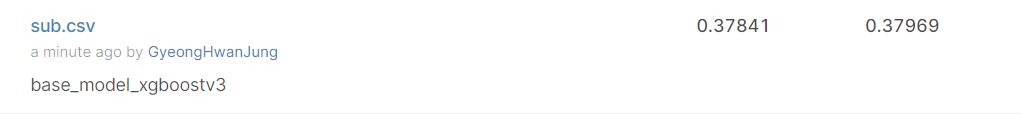

## XGBoost 결과 정리(사진 아래부터)
1. xgboost_v2 : parameter[learning_rate=0.3, max_depth=6, n_estimators=400](RandomizedSearchCV 사용)  **0.37781**
2. xgboost_v3 : parameter[learning_rate=0.3, max_depth=4, n_estimators=400] **0.37821**
3. xgboost_53_v1,v3 : 피처 추가(53개), parameter[learning_rate=0.3, max_depth=4, n_estimators=400] **0.37876(최고점), 0.37841**
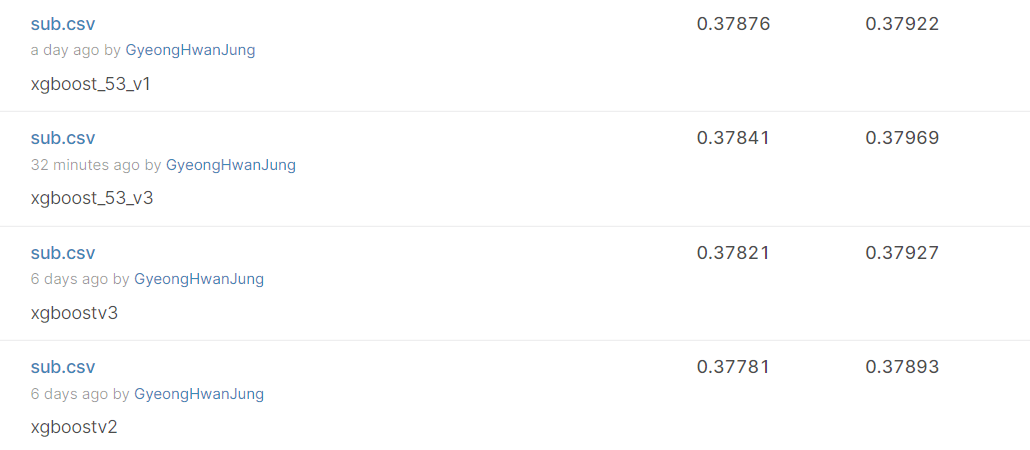

### Feature Importance
* f score는 각 피처들의 독립적인 중요도를 나타낸다.
* 공통적으로 중요도가 높은 피처 : ***UP_order_-2, UP_order_-3, UP_order_-1, UP_total_reorders, P_reorder_rate,  UP_reoder_ratio***

1. xgboostv2, 캐글:**0.37781**
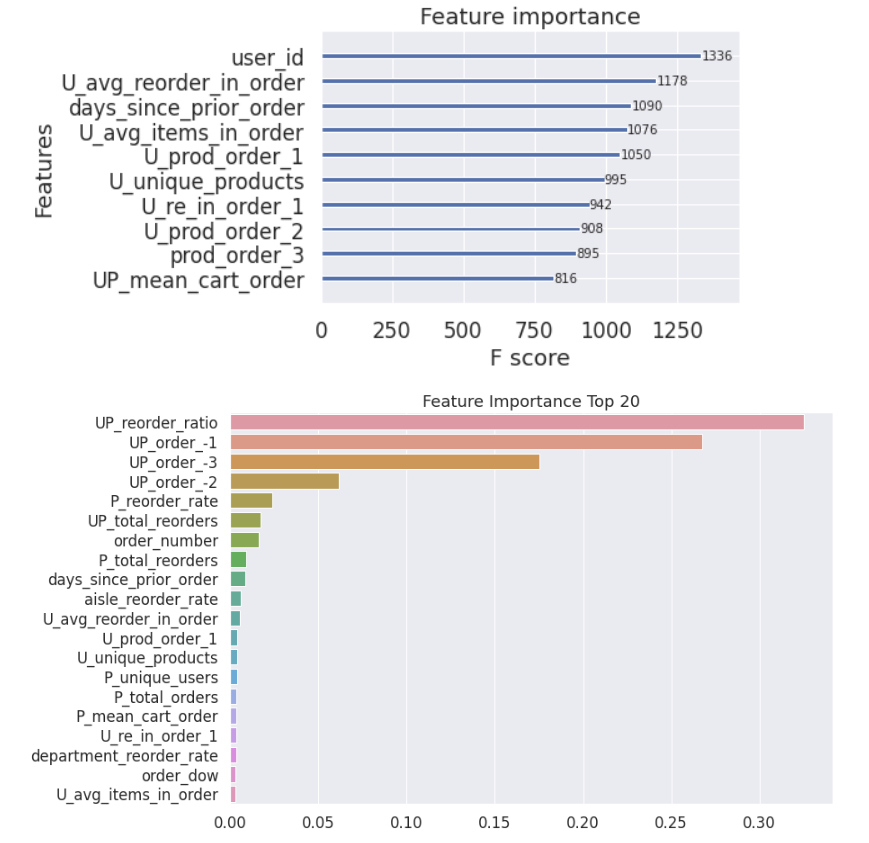
2. xgboostv3, 캐글:**0.37821**
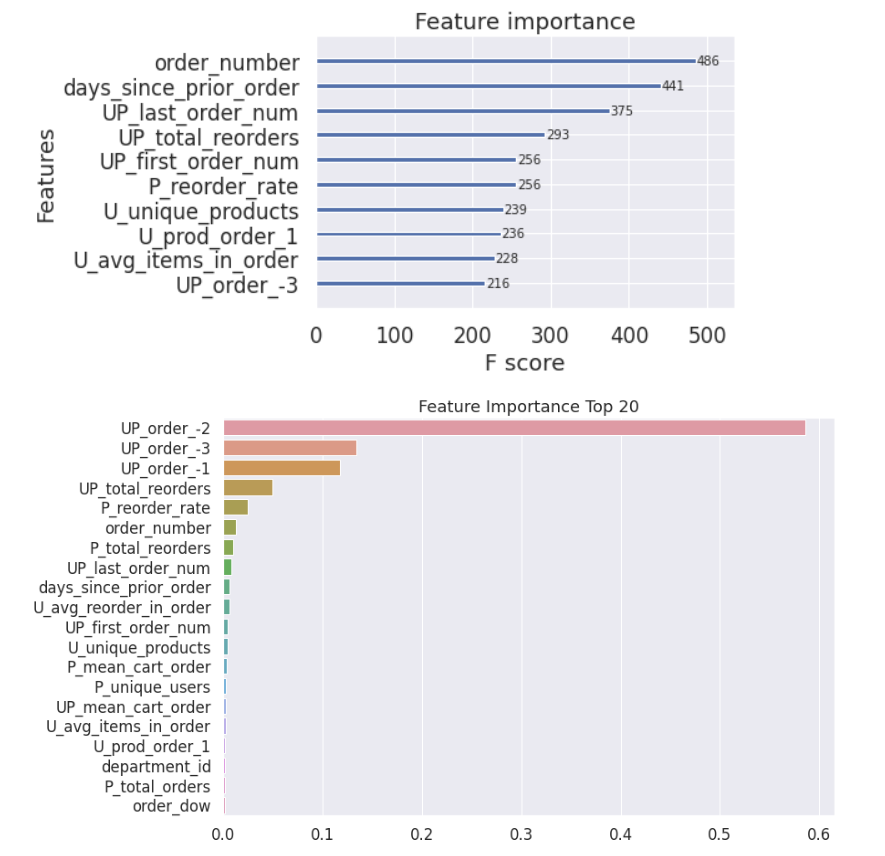
3. xgboost_53_v1, 캐글:**0.37876**
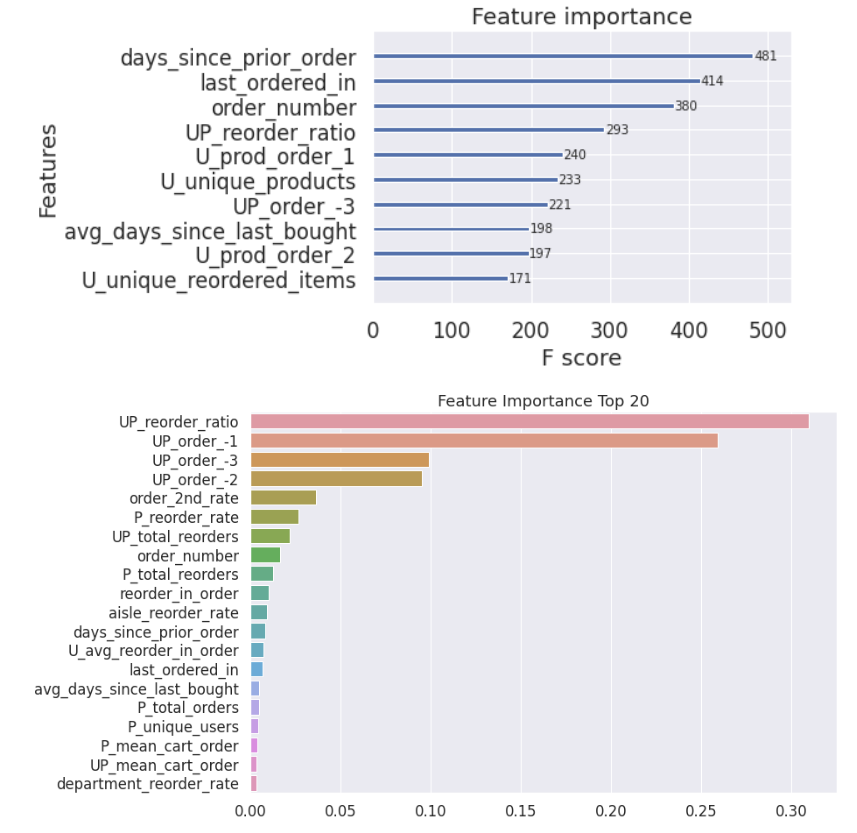

## Catboost

In [ ]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install catboost
from catboost import CatBoostClassifier
from sklearn.model_selection import GroupKFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import RandomizedSearchCV

clf_CB = CatBoostClassifier(task_type = "GPU") # 모델
# distributions = dict(learning_rate=[0.01, 0.1, 0.2, 0.3],n_estimators=[500, 1000, 1500],max_depth=[5, 10, 15, 20],class_weights=[{0:1,1:2},{0:1,1:4},{0:1,1:6}]) 

# CB_Randomized = RandomizedSearchCV(clf_CB,param_distributions=distributions,scoring='f1',return_train_score=True,cv=3)
# CB_Randomized.fit(X, y)
# CB_Randomized.best_params_

gkf = GroupKFold(n_splits=3)  # Group KFold
gkf = gkf.split(X, y, groups=X['user_id'].values)

y_scores = cross_val_predict(clf_CB, X, y, cv=gkf, method='predict_proba')

In [ ]:
#CB_Randomized.best_params_ # 'class_weights': {0: 1, 1: 6}, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1500

In [ ]:
# precision, recall, threshold 뽑아내기
precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:,1])

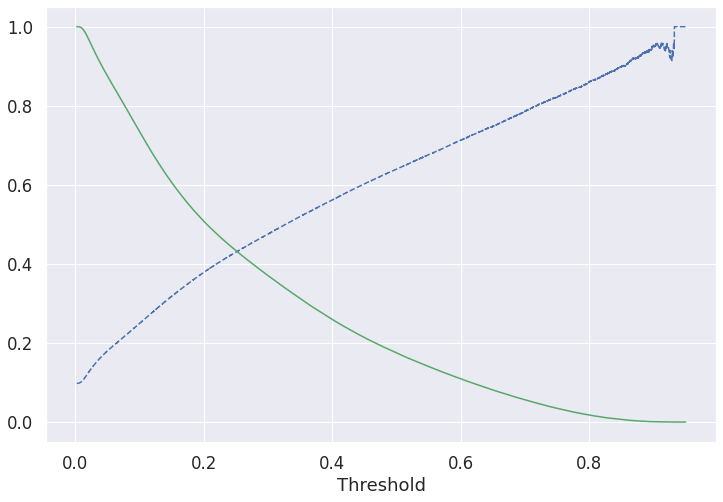

In [ ]:
# threshold에 따른 precision과 recall의 trade_off 확인하기
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(12,8))
    plt.plot(thresholds, precisions[:-1], 'b--', label='precisions')
    plt.plot(thresholds, recalls[:-1], 'g-', label='recalls')
    plt.xlabel('Threshold')
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [ ]:
for thre in range(20, 30):
    temp_thre = thre * 0.01
    temp_y_pred = (y_scores[:, 1] >= temp_thre).astype(np.uint8)
    print('threshold :', temp_thre, f1_score(y, temp_y_pred))

threshold : 0.2 0.43377336121119536
threshold : 0.21 0.4347048910345592
threshold : 0.22 0.4349278645247301
threshold : 0.23 0.43433912561077576
threshold : 0.24 0.4334259477113117
threshold : 0.25 0.4317520527017568
threshold : 0.26 0.4295617071635898
threshold : 0.27 0.4271362020002235
threshold : 0.28 0.4239749528165465
threshold : 0.29 0.42060903456918997


In [ ]:
clf_CB = CatBoostClassifier(class_weights={0: 1, 1: 4},learning_rate=0.1,max_depth=10,n_estimators=100,task_type = "GPU",verbose = False)
clf_CB.fit(X, y)

y_pred = clf_CB.predict_proba(test_df)
final_y_pred = (y_pred[:, 1] >= 0.22).astype(np.uint8)
test_df['reordered'] = final_y_pred

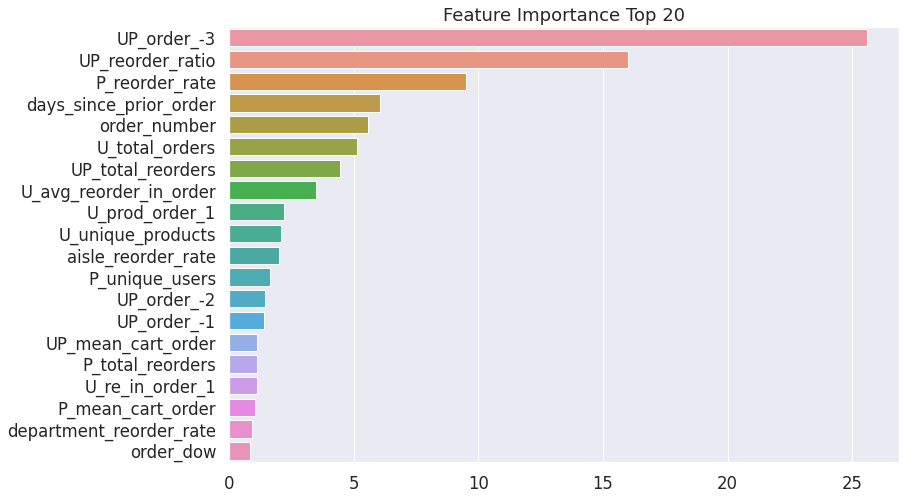

In [ ]:
import seaborn as sns

ft_importance_values = clf_CB.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(12,8))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

### submission 생성/제출

In [ ]:
orders = pd.read_pickle(PATH + 'orders.pkl')

sub = orders[orders.eval_set == 'test'][['order_id', 'user_id']].reset_index(drop=True)

sub_prods = test_df[test_df['reordered'] == 1].groupby('user_id')['product_id'].agg(lambda x: ' '.join(map(str,x))).reset_index()

sub = sub.merge(sub_prods, on='user_id', how='left')
sub.drop('user_id', axis=1, inplace=True)
sub.fillna('None', inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

#### 캐글 API 키를 사용해서 바로 submit하기

In [ ]:
# 캐글 API 키 설정 사용하기
!mkdir -p ~/.kaggle
%cd /content/drive/MyDrive/
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle
%cd /content

# submit코드
!kaggle competitions submit -c instacart-market-basket-analysis -f sub.csv -m "base_modelv2_catboost"

/content/drive/MyDrive
/content
100% 11.5M/11.5M [00:00<00:00, 35.2MB/s]
Successfully submitted to Instacart Market Basket Analysis

## Catboost 결과 정리
1. base_model_catboost : parameter[learning_rate=0.1, max_depth = 10, n_estimators = 100, class_weights ={0:1, 1:4}] **0.30499**
2. catboostv2 : parameter[learning_rate=0.1, max_depth = 15, n_estimators = 1000, class_weights ={0:1, 1:4}] **0.33729**
3. catboost_53_v3 : 피처 53개, parameter[(class_weights={0: 1, 1: 2},learning_rate=0.01,max_depth=10,n_estimators=1500)] **0.35825**
4. after_reorder_ratio_feats_catboost : reorder_ratio 피처 추가 **0.37265**
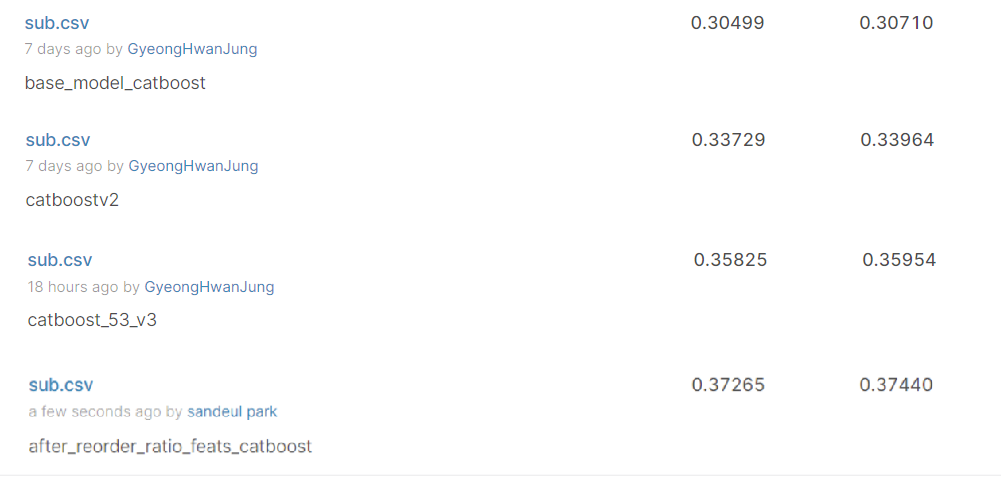

### Feature Importance
* Catboost모델은 파라미터 튜닝을 통한 성능향상도 쉽지 않았고, feature importance를 찍어봤을때 공통된 중요 피처를 찾기 힘들었습니다.
1. catboostv2, 캐글:**0.33729**
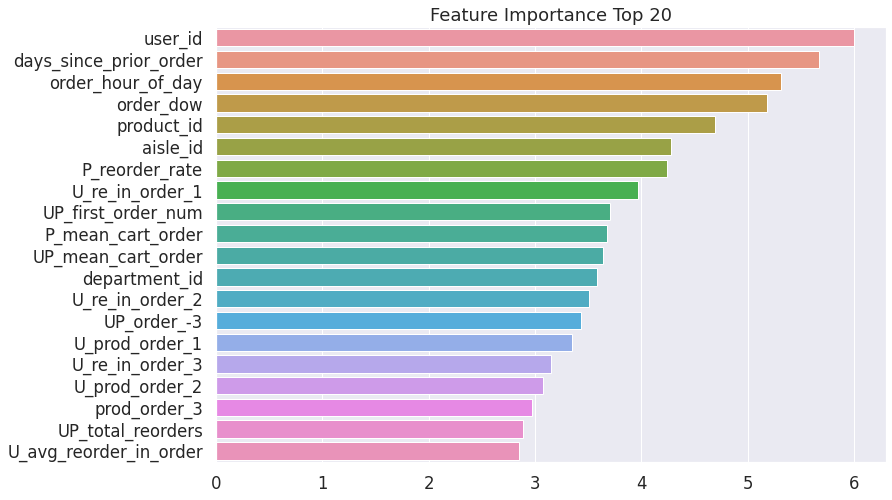
2. catboost_53_v3, 캐글:**0.35825**
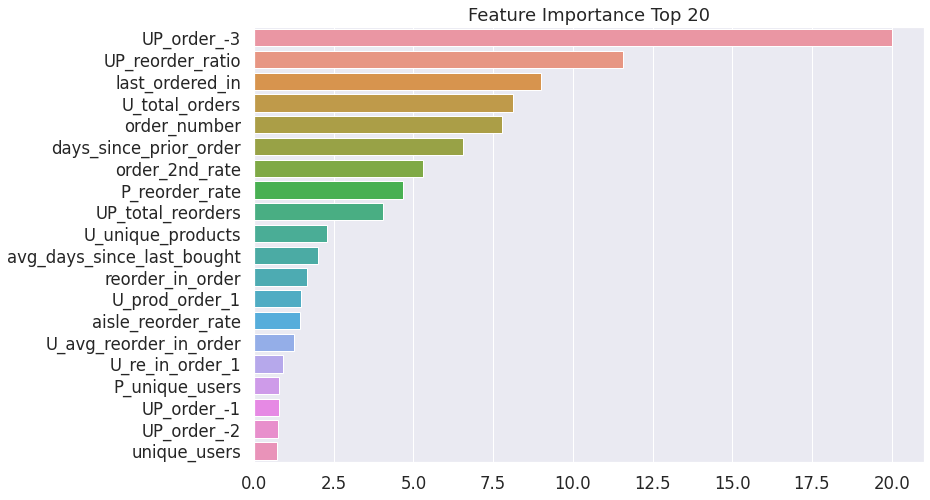